## NiO M&M 2023 Notebook

Georgios Varnavides (gvarnavides@berkeley.edu)  
July 23 2023

This notebook perfoms the magnetic simulation necessary for the ptychographic analysis presented at M&M 2023 during [this presentation](https://gvarnavides.com/2023mm-presentation/).

In [19]:
import abtem
import ase
import spglib
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, rotate
from scipy.signal import fftconvolve, oaconvolve

### Atomic Models

In [9]:
def make_standardized_primitive_cell(atoms_object,no_idealize=False):
    
    primitive_cell,primitive_positions,primitive_numbers = spglib.standardize_cell(
    atoms_object,
    no_idealize= no_idealize,
    to_primitive=True)

    return ase.Atoms(
        scaled_positions=primitive_positions,
        numbers=primitive_numbers,
        cell=primitive_cell,
        pbc=True
    )

def pretty_print_transform(transform):
    print('euler angles (degrees): \t x = {:.3f}, \t y = {:.3f}, \t z = {:.3f}'.format(*transform[0] / np.pi * 180))
    print('normal strains (percent): \t x = {:.3f}, \t y = {:.3f}, \t z = {:.3f}'.format(*(transform[1] - 1) * 100))
    print('shear strains (percent): \t xy = {:.3f}, \t xz = {:.3f}, \t xz = {:.3f}'.format(*(transform[2]) * 100))


In [10]:
NiO_poscar = ase.io.read("data/NiO.poscar",format="vasp")

NiO_111_slab= ase.build.surface(NiO_poscar, (1, 1, 1), 6,periodic=True)
NiO_111_slab.rotate('y','z',rotate_cell=True)
NiO_111_slab.rotate('x','-z',rotate_cell=True)
NiO_111_slab.rotate('x','y',rotate_cell=True)

oxygen_cutoff = NiO_111_slab.positions[
    np.where(
    (NiO_111_slab.numbers==8) & (NiO_111_slab.positions[:,0]>10) & (NiO_111_slab.positions[:,0]<12)
)[0][0],0]

NiO_111_slab.positions[:,0] += (NiO_111_slab.cell[-1,0]-oxygen_cutoff)
NiO_111_slab.wrap()

NiO_111_reflected = NiO_111_slab.copy()
NiO_111_reflected.positions[:,0]-=  NiO_111_slab.cell[-1,0]
NiO_111_reflected.positions[:,0] = -NiO_111_reflected.positions[:,0]
NiO_111_reflected.wrap()
NiO_111_reflected.positions[:,0]+=  NiO_111_slab.cell[-1,0]

NiO_111_twin = NiO_111_slab + NiO_111_reflected
NiO_111_twin.cell = NiO_111_twin.cell*(2,1,1)
NiO_111_twin.wrap()

_,transformation_matrix = NiO_111_twin.cell.standard_form()
NiO_111_twin = ase.build.make_supercell(
    NiO_111_twin,
    transformation_matrix.T
)

NiO_111_slab = ase.build.make_supercell(
    NiO_111_slab,
    transformation_matrix.T
)

standardized_cell_twin = make_standardized_primitive_cell(NiO_111_twin)

ortho_twin, ortho_tf = abtem.structures.orthogonalize_cell(standardized_cell_twin,return_transform=True)
pretty_print_transform(ortho_tf)

ortho_twin.rotate('-x','z',rotate_cell=True)

euler angles (degrees): 	 x = 0.000, 	 y = -0.000, 	 z = 0.000
normal strains (percent): 	 x = 0.000, 	 y = -0.000, 	 z = -0.000
shear strains (percent): 	 xy = 0.000, 	 xz = 0.000, 	 xz = 0.000


#### Bulk

'R-3m (166)'

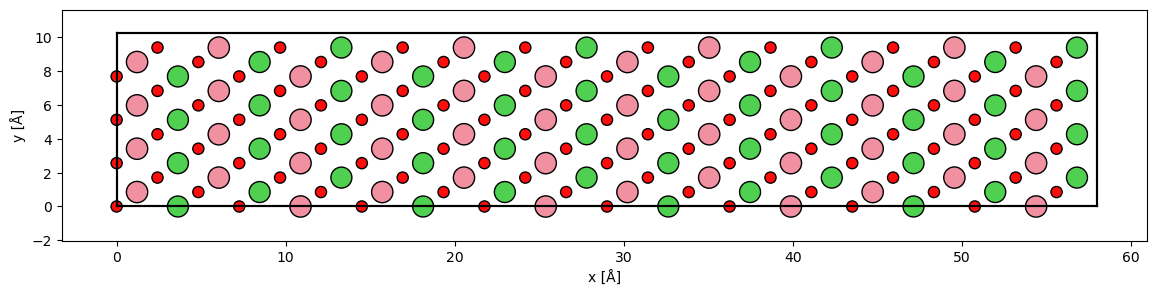

In [11]:
afm_slab = NiO_111_slab.copy()
afm_slab.numbers[[40,41,42,43,10,11,9,8,25,24,26,27]]=27
standardized_cell = make_standardized_primitive_cell(afm_slab)
afm_bulk = abtem.structures.orthogonalize_cell(standardized_cell)
afm_bulk.rotate('-x','z',rotate_cell=True)
afm_bulk.translate(-afm_bulk.positions[21])
afm_bulk.wrap()
afm_bulk_copout = ase.build.make_supercell(
    afm_bulk,
    transformation_matrix.T
)
afm_bulk *= (1,1,2)

fig,ax = plt.subplots(figsize=(14,3))
abtem.show_atoms(afm_bulk*(1,2,2),ax=ax);

standardized_cell_afm_bulk = make_standardized_primitive_cell(afm_bulk)
#standardized_cell_afm_bulk.write('NiO_afm_bulk.vasp',format='vasp',direct=True)
spglib.get_spacegroup(standardized_cell_afm_bulk)

#### AFM Twin

'P6_3mc (186)'

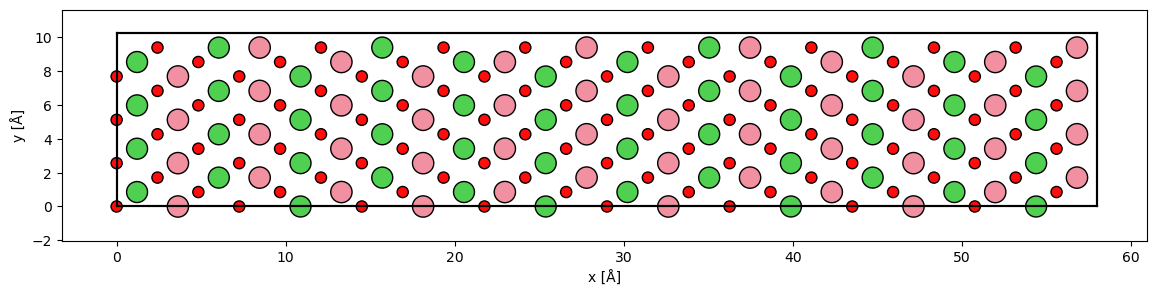

In [12]:
afm_twin = ortho_twin.copy()
afm_twin.numbers[[16,29,20,45,6,36,2,33,10,27,12,40]]=27

fig,ax = plt.subplots(figsize=(14,3))
abtem.show_atoms(afm_twin*(1,2,2),ax=ax)

standardized_cell_afm_twin = make_standardized_primitive_cell(afm_twin)
standardized_cell_afm_twin.write('NiO_afm_twin.vasp',format='vasp',direct=True)
spglib.get_spacegroup(standardized_cell_afm_twin)

#### Mixed Twin

'Pnma (62)'

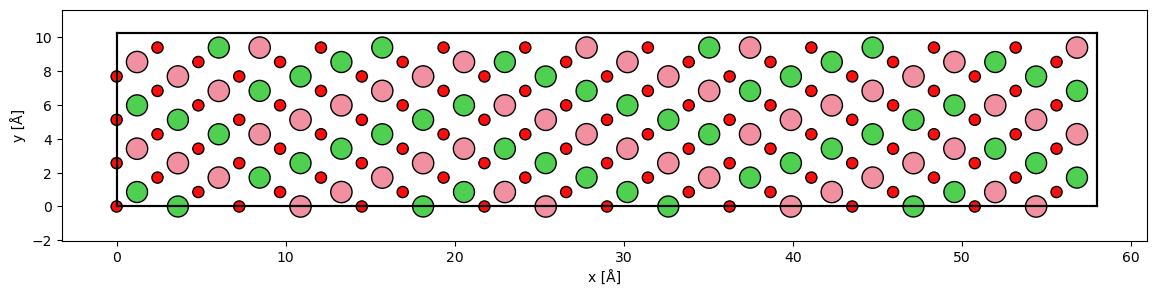

In [13]:
mix_twin = ortho_twin.copy()
mix_twin.numbers[[16,18,45,8,36,25,33,0,10,31,40,14]]=27
fig,ax = plt.subplots(figsize=(14,3))
abtem.show_atoms(mix_twin*(1,2,2),ax=ax)

standardized_cell_mix_twin = make_standardized_primitive_cell(mix_twin)
standardized_cell_mix_twin.write('NiO_mix_twin.vasp',format='vasp',direct=True)
spglib.get_spacegroup(standardized_cell_mix_twin)

### Magnetic Potentials

Note: The primitive cell magnetizations were obtained using collinear DFT calculations with [JDFTx](https://jdftx.org/).

Below we import these, re-map them on our supercell and perform our 4D-STEM simulation.

#### Bulk

In [14]:
primitive_cell_volume = np.fromfile('data/NiO-bulk-totalE.n_diff').reshape((168,60,36))
uvw_init = afm_bulk_copout.cell.array
uvw_init

array([[14.5018988 ,  0.        ,  0.        ],
       [ 0.        ,  5.12719549,  0.        ],
       [ 0.        ,  0.        ,  2.9601877 ]])

In [15]:
u0 = np.array([2,0,0])
v0 = np.array([0,1,0])
w0 = np.array([0,0,1])

V0 = np.abs(np.cross(uvw_init[0,:],uvw_init[1,:]) @ uvw_init[2,:])

u = uvw_init.T @ u0
v = uvw_init.T @ v0
w = uvw_init.T @ w0

V = np.abs(np.cross(u,v) @ w)

print('volume change = ' + str(V / V0))
uvw = np.vstack((u,v,w))

print(np.round(uvw,decimals=8))

cell_dim = np.sqrt(np.sum(uvw**2,axis=1))
n = uvw / cell_dim[:,None]
uvw_proj = uvw_init @ np.linalg.inv(n)

print(np.round(uvw_proj,decimals=3))

volume change = 2.0
[[29.0037976   0.          0.        ]
 [ 0.          5.12719549  0.        ]
 [ 0.          0.          2.9601877 ]]
[[14.502  0.     0.   ]
 [ 0.     5.127  0.   ]
 [ 0.     0.     2.96 ]]


In [16]:
# sampling of input
voxel_input = np.sqrt(np.sum(uvw_init**2,axis=1)) / primitive_cell_volume.shape

# sampling of output
voxel_output = np.min(voxel_input)
size_output = np.round(cell_dim / voxel_output).astype('int')
voxel_output = cell_dim / size_output

# Generate output volume
vol_output = np.zeros(size_output)
vol_count = np.zeros(size_output)

for a0 in range(2):
    # Projected coordinate system
    x0 = np.linspace(0,1,primitive_cell_volume.shape[0],endpoint=False) + a0
    y0 = np.linspace(0,1,primitive_cell_volume.shape[1],endpoint=False)
    z0 = np.linspace(0,1,primitive_cell_volume.shape[2],endpoint=False)
    [xa,ya,za] = np.meshgrid(x0,y0,z0,indexing='ij')
    p0 = np.vstack((xa.ravel(),ya.ravel(),za.ravel()))
    p = uvw_proj.T @ p0
    p_inds = p / voxel_output[:,None]
    
    # trilinear sampling
    x = p_inds[0,:]
    y = p_inds[1,:]
    z = p_inds[2,:]
    xF = np.floor(x).astype('int')
    yF = np.floor(y).astype('int')
    zF = np.floor(z).astype('int')
    dx = x - xF
    dy = y - yF
    dz = z - zF
    
    # resample output
    inds_1D = np.ravel_multi_index(
        np.hstack([
            [xF  ,yF  ,zF  ], 
            [xF+1,yF  ,zF  ], 
            [xF  ,yF+1,zF  ], 
            [xF+1,yF+1,zF  ], 
            [xF  ,yF  ,zF+1], 
            [xF+1,yF  ,zF+1], 
            [xF  ,yF+1,zF+1], 
            [xF+1,yF+1,zF+1], 
        ]),
        size_output, 
        mode=['wrap','wrap','wrap'])
    weights = np.hstack((
            (1-dx)*(1-dy)*(1-dz),
            (  dx)*(1-dy)*(1-dz),
            (1-dx)*(  dy)*(1-dz),
            (  dx)*(  dy)*(1-dz),
            (1-dx)*(1-dy)*(  dz),
            (  dx)*(1-dy)*(  dz),
            (1-dx)*(  dy)*(  dz),
            (  dx)*(  dy)*(  dz),
    ))
    vol_count += np.reshape(np.bincount(
        inds_1D,
        weights=weights,
        minlength=vol_count.size),size_output)
    vol_output += np.reshape(np.bincount(
        inds_1D,
        weights=weights * np.tile(primitive_cell_volume.ravel(),8),
        minlength=vol_count.size),size_output)

# kernel density estimate
sigma = 0.25
vol_count = gaussian_filter(vol_count, sigma, mode ='wrap')
vol_count[vol_count==0.0] = np.inf
vol_output = gaussian_filter(vol_output, sigma, mode ='wrap')
vol_output /= vol_count

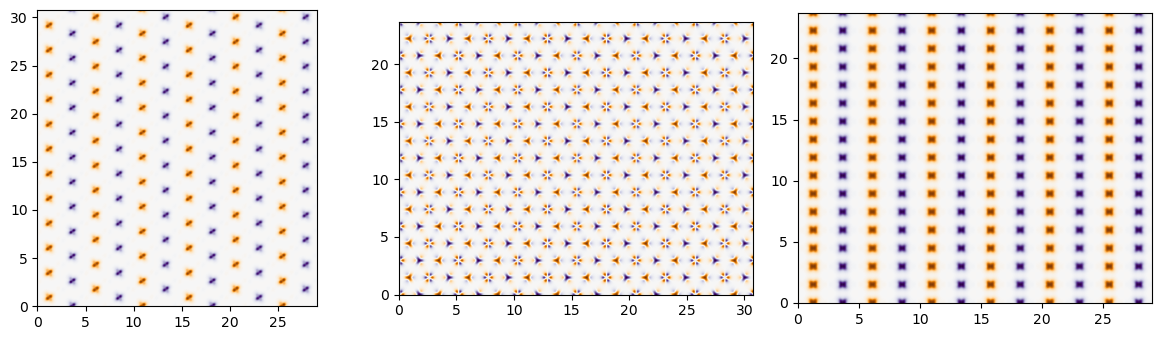

In [18]:
# plot magnetization

cmap = 'PuOr'
tile = (1,6,8)

tiled_output = np.tile(vol_output,tile)

extent = voxel_output*vol_output.shape*tile

extent_xy = [
    0,extent[0],
    0,extent[1]
    ]

extent_yz = [
    0,extent[1],
    0,extent[2]
    ]

extent_xz = [
    0,extent[0],
    0,extent[2]
    ]

fig,ax = plt.subplots(1,3,figsize=(12,3.5))
ax[0].imshow(
    np.sum(tiled_output,axis=2).T,
    cmap=cmap,
    origin='lower',
    extent=extent_xy
)
ax[1].imshow(
    np.sum(tiled_output,axis=0).T ,
    cmap=cmap,
    origin='lower',
    extent=extent_yz
)
ax[2].imshow(
    np.sum(tiled_output,axis=1).T,
    cmap=cmap,
    origin='lower',
    extent=extent_xz
);

fig.tight_layout()

In [20]:
tiled_output = np.tile(vol_output,(2,2,2))

xx,yy,zz = tuple(np.linspace(-(shape-1)/2,(shape-1)/2,shape)*sx for shape,sx in zip(vol_output.shape,voxel_output))
xx,yy,zz = np.meshgrid(xx,yy,zz,indexing='ij')

rvec = np.stack((xx, yy, zz), axis=0)
r = np.sqrt(xx**2 + yy**2 + zz**2)
r3 = r**3
r3[r3==0]=np.inf

rvec_over_rcubed = rvec/r3[None]

mu = np.array([0,1,0])
mu_cross_r = np.cross(mu, rvec_over_rcubed, axis=0) 

vector_potential_x =fftconvolve(mu_cross_r[0],tiled_output,mode='same')
vector_potential_y =fftconvolve(mu_cross_r[1],tiled_output,mode='same')
vector_potential_z =fftconvolve(mu_cross_r[2],tiled_output,mode='same')

vector_potential_x_tiled = np.tile(vector_potential_x,tile)
vector_potential_y_tiled = np.tile(vector_potential_y,tile)
vector_potential_z_tiled = np.tile(vector_potential_z,tile)

In [ ]:
# from ase.io import write
# write("NiO-bulk_atoms.xyz",afm_bulk_copout)

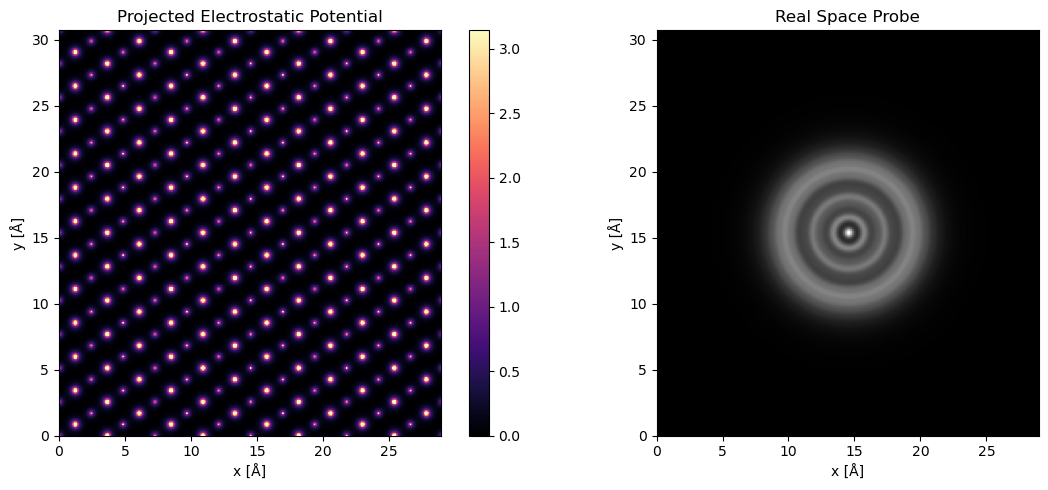

In [21]:
# Electrostatic Potential

atoms_final = afm_bulk_copout*(2,6,8)
atoms_final.numbers[atoms_final.numbers==27]=28

electrostatic_potential = abtem.Potential(
    atoms_final,
    sampling=0.05,
    device='gpu',
    projection='infinite',
    parametrization='kirkland'
).build()

probe = abtem.Probe(
    defocus=300,
    semiangle_cutoff=25,
    energy=200e3,
    device='gpu'
)

probe.match_grid(electrostatic_potential)
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
(electrostatic_potential.project()*abtem.utils.energy2sigma(200e3)).show(cmap='magma',figsize=(4,4),title='Projected Electrostatic Potential',ax=ax1,cbar=True,vmax=np.pi)
probe.show(figsize=(4,4),title='Real Space Probe',ax=ax2)
fig.tight_layout()

In [22]:
from cupyx.scipy.ndimage import zoom
import cupy as cp

vector_potential_z_resized = vector_potential_z_tiled.copy().transpose(1, 0, 2)
zoom_factor = np.array(electrostatic_potential.array.shape)/np.array(vector_potential_z_resized.shape)

vector_potential_z_resized = zoom(cp.asarray(vector_potential_z_resized),zoom_factor)
max_magnetic = cp.sum(vector_potential_z_resized,axis=0).max()
vector_potential_z_resized *= 2e-4*(atoms_final.cell.lengths()[2])/abtem.utils.energy2sigma(probe.energy)/max_magnetic

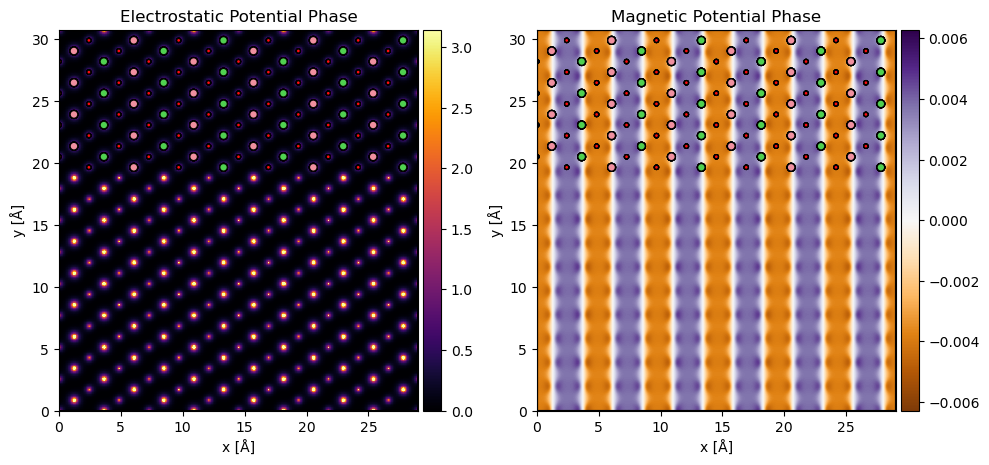

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

NiO_111_top_left = afm_bulk_copout*(2,6,8)
del NiO_111_top_left[np.where((NiO_111_top_left.positions[:,1]<19))[0]]

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6))

_,im1 = (electrostatic_potential.project()*abtem.utils.energy2sigma(probe.energy)).show(
    cmap='inferno',ax=ax1,vmax=np.pi)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax, orientation='vertical')

abtem.show_atoms(NiO_111_top_left, ax = ax1,scale_atoms=0.25)
ax1.set_xlim(extent_xy[0],extent_xy[1])
ax1.set_ylim(extent_xy[2],extent_xy[3])


ax1.set_title("Electrostatic Potential Phase")

im2=ax2.imshow(
    np.sum(vector_potential_z_resized.get()*abtem.utils.energy2sigma(probe.energy),axis=0).T,
    cmap='PuOr',
    origin='lower',
    vmin=-np.pi*2e-3,
    vmax=np.pi*2e-3,
    extent=extent_xy
)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

abtem.show_atoms(NiO_111_top_left, ax = ax2,scale_atoms=0.25)
ax2.set_xlim(extent_xy[0],extent_xy[1])
ax2.set_ylim(extent_xy[2],extent_xy[3])
ax2.set_title("Magnetic Potential Phase");

fig.tight_layout();

In [24]:
ground_truth_electrostatic = (electrostatic_potential.project()*abtem.utils.energy2sigma(probe.energy)).array
ground_truth_magnetic = np.sum(vector_potential_z_resized.get()*abtem.utils.energy2sigma(probe.energy),axis=0)

In [ ]:
# np.save("NiO-bulk_ground-truth_electrostatic.npy",ground_truth_electrostatic)
# np.save("NiO-bulk_ground-truth_magnetic.npy",ground_truth_magnetic)

In [26]:
# Simulation

resample = probe.angular_sampling[0]
pixelated_detector = abtem.PixelatedDetector(max_angle=70,resample=(resample,)*2)
gridscan = abtem.GridScan(
    (0, 0), electrostatic_potential.extent, sampling=2,
    endpoint=True
)

modified_potential_forward = electrostatic_potential.copy()
modified_potential_forward._array += vector_potential_z_resized

measurement_forward = probe.scan(
    potential=modified_potential_forward,
    scan=gridscan,
    detectors=pixelated_detector, 
)

modified_potential_reverse = electrostatic_potential.copy()
modified_potential_reverse._array -= vector_potential_z_resized

measurement_reverse = probe.scan(
    potential=modified_potential_reverse,
    scan=gridscan,
    detectors=pixelated_detector, 
)

Scan:   0%|          | 0/256 [00:00<?, ?it/s]

Scan:   0%|          | 0/256 [00:00<?, ?it/s]

In [27]:
from abtem.noise import poisson_noise
measurement_forward_noisy = poisson_noise(measurement_forward,dose=1e6)
measurement_reverse_noisy = poisson_noise(measurement_reverse,dose=1e6)

In [ ]:
# py4DSTEM.save("NiO-bulk_forward_1e6.h5",datacube_forward)
# py4DSTEM.save("NiO-bulk_reverse_1e6.h5",datacube_reverse)

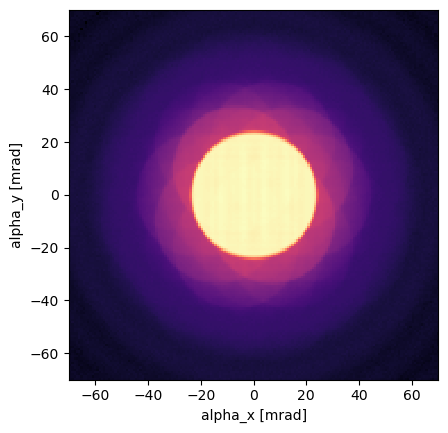

In [28]:
measurement_forward_noisy.mean((0,1)).show(power=0.25,cmap='magma');

In [30]:
from py4DSTEM import DataCube

datacube_forward = DataCube(measurement_forward_noisy.copy().array)
calibration_forward = datacube_forward.calibration
calibration_forward.set_R_pixel_size(measurement_forward_noisy.calibrations[0].sampling)
calibration_forward.set_R_pixel_units('A')
calibration_forward.set_Q_pixel_size(measurement_forward_noisy.calibrations[-1].sampling)
calibration_forward.set_Q_pixel_units('mrad')

datacube_reverse = DataCube(measurement_reverse_noisy.copy().array)
calibration_reverse = datacube_reverse.calibration
calibration_reverse.set_R_pixel_size(measurement_reverse_noisy.calibrations[0].sampling)
calibration_reverse.set_R_pixel_units('A')
calibration_reverse.set_Q_pixel_size(measurement_reverse_noisy.calibrations[-1].sampling)
calibration_reverse.set_Q_pixel_units('mrad')

datacube_forward.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.8646916077252439
             R_pixel_size:    1.9335865064119269
             Q_pixel_units:   mrad
             R_pixel_units:   A
)

In [ ]:
# py4DSTEM.save("NiO-bulk_forward_1e6.h5",datacube_forward)
# py4DSTEM.save("NiO-bulk_reverse_1e6.h5",datacube_reverse)

#### AFM Twin

In [31]:
primitive_cell_volume = np.fromfile('NiO-afm-twin-totalE.n_diff').reshape((36,36,328))
uvw_init = standardized_cell_afm_twin.cell.array
uvw_init

array([[ 2.9601877 ,  0.        ,  0.        ],
       [-1.48009385,  2.56359775,  0.        ],
       [ 0.        ,  0.        , 29.0037976 ]])

In [32]:
symm_dataset = spglib.get_symmetry_dataset(afm_twin)
np.round(symm_dataset['transformation_matrix'].T,decimals=4)

array([[-1., -1.,  0.],
       [-1.,  1.,  0.],
       [ 0.,  0., -1.]])

In [33]:
w0 = np.array([-1,-1,0])
v0 = np.array([-1,1,0])
u0 = np.array([0,0,-1])

V0 = np.abs(np.cross(uvw_init[0,:],uvw_init[1,:]) @ uvw_init[2,:])

u = uvw_init.T @ u0
v = uvw_init.T @ v0
w = uvw_init.T @ w0

V = np.abs(np.cross(u,v) @ w)

print('volume change = ' + str(V / V0))
uvw = np.vstack((u,v,w))

print(np.round(uvw,decimals=8))

cell_dim = np.sqrt(np.sum(uvw**2,axis=1))
n = uvw / cell_dim[:,None]
uvw_proj = uvw_init @ np.linalg.inv(n)

print(np.round(uvw_proj,decimals=3))

volume change = 1.9999999999999998
[[  0.           0.         -29.0037976 ]
 [ -4.44028154   2.56359775   0.        ]
 [ -1.48009385  -2.56359775   0.        ]]
[[  0.     -2.564  -1.48 ]
 [  0.      2.564  -1.48 ]
 [-29.004   0.      0.   ]]


In [34]:
# sampling of input
voxel_input = np.sqrt(np.sum(uvw_init**2,axis=1)) / primitive_cell_volume.shape

# sampling of output
voxel_output = np.min(voxel_input)
size_output = np.round(cell_dim / voxel_output).astype('int')
voxel_output = cell_dim / size_output

# Generate output volume
vol_output = np.zeros(size_output)
vol_count = np.zeros(size_output)

for a0 in range(2):
    # Projected coordinate system
    x0 = np.linspace(0,1,primitive_cell_volume.shape[0],endpoint=False) 
    y0 = np.linspace(0,1,primitive_cell_volume.shape[1],endpoint=False) + a0
    z0 = np.linspace(0,1,primitive_cell_volume.shape[2],endpoint=False)
    [xa,ya,za] = np.meshgrid(x0,y0,z0,indexing='ij')
    p0 = np.vstack((xa.ravel(),ya.ravel(),za.ravel()))
    p = uvw_proj.T @ p0
    p_inds = p / voxel_output[:,None]
    
    # trilinear sampling
    x = p_inds[0,:]
    y = p_inds[1,:]
    z = p_inds[2,:]
    xF = np.floor(x).astype('int')
    yF = np.floor(y).astype('int')
    zF = np.floor(z).astype('int')
    dx = x - xF
    dy = y - yF
    dz = z - zF
    
    # resample output
    inds_1D = np.ravel_multi_index(
        np.hstack([
            [xF  ,yF  ,zF  ], 
            [xF+1,yF  ,zF  ], 
            [xF  ,yF+1,zF  ], 
            [xF+1,yF+1,zF  ], 
            [xF  ,yF  ,zF+1], 
            [xF+1,yF  ,zF+1], 
            [xF  ,yF+1,zF+1], 
            [xF+1,yF+1,zF+1], 
        ]),
        size_output, 
        mode=['wrap','wrap','wrap'])
    weights = np.hstack((
            (1-dx)*(1-dy)*(1-dz),
            (  dx)*(1-dy)*(1-dz),
            (1-dx)*(  dy)*(1-dz),
            (  dx)*(  dy)*(1-dz),
            (1-dx)*(1-dy)*(  dz),
            (  dx)*(1-dy)*(  dz),
            (1-dx)*(  dy)*(  dz),
            (  dx)*(  dy)*(  dz),
    ))
    vol_count += np.reshape(np.bincount(
        inds_1D,
        weights=weights,
        minlength=vol_count.size),size_output)
    vol_output += np.reshape(np.bincount(
        inds_1D,
        weights=weights * np.tile(primitive_cell_volume.ravel(),8),
        minlength=vol_count.size),size_output)

# kernel density estimate
sigma = 0.25
vol_count = gaussian_filter(vol_count, sigma, mode ='wrap')
vol_count[vol_count==0.0] = np.inf
vol_output = gaussian_filter(vol_output, sigma, mode ='wrap')
vol_output /= vol_count

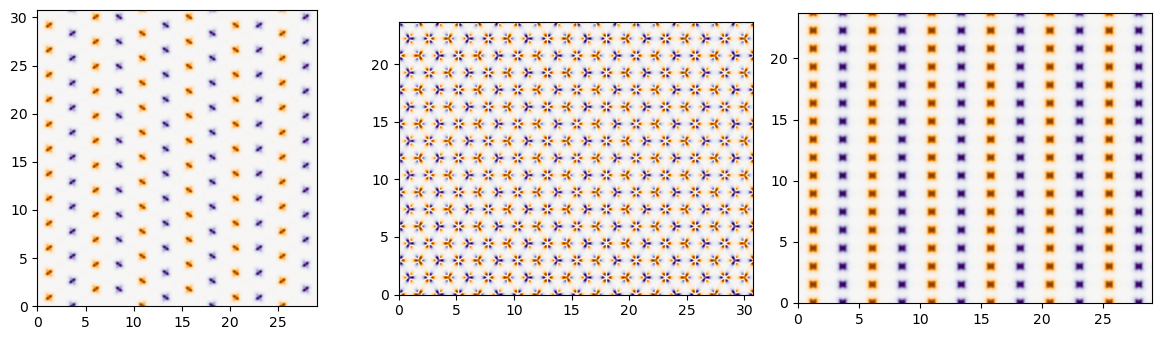

In [35]:
# plot magnetization

cmap = 'PuOr'
tile = (1,6,8)

tiled_output = np.tile(vol_output,tile)

extent = voxel_output*vol_output.shape*tile
#extent *= np.array([0.9428,1,1]) # Somehow one of the dimensions is off by 5% ?

extent_xy = [
    0,extent[0],
    0,extent[1]
    ]

extent_yz = [
    0,extent[1],
    0,extent[2]
    ]

extent_xz = [
    0,extent[0],
    0,extent[2]
    ]

fig,ax = plt.subplots(1,3,figsize=(12,3.5))
ax[0].imshow(
    np.sum(tiled_output,axis=2).T,
    cmap=cmap,
    origin='lower',
    extent=extent_xy
)
ax[1].imshow(
    np.sum(tiled_output,axis=0).T ,
    cmap=cmap,
    origin='lower',
    extent=extent_yz
)
ax[2].imshow(
    np.sum(tiled_output,axis=1).T,
    cmap=cmap,
    origin='lower',
    extent=extent_xz
);

fig.tight_layout()

In [36]:

tiled_output = np.tile(vol_output,(2,2,2))

xx,yy,zz = tuple(np.linspace(-(shape-1)/2,(shape-1)/2,shape)*sx for shape,sx in zip(vol_output.shape,voxel_output))
xx,yy,zz = np.meshgrid(xx,yy,zz,indexing='ij')

rvec = np.stack((xx, yy, zz), axis=0)
r = np.sqrt(xx**2 + yy**2 + zz**2)
r3 = r**3
r3[r3==0]=np.inf

rvec_over_rcubed = rvec/r3[None]

mu = np.array([0,1,0])
mu_cross_r = np.cross(mu, rvec_over_rcubed, axis=0) 

vector_potential_x =fftconvolve(mu_cross_r[0],tiled_output,mode='same')
vector_potential_y =fftconvolve(mu_cross_r[1],tiled_output,mode='same')
vector_potential_z =fftconvolve(mu_cross_r[2],tiled_output,mode='same')

vector_potential_x_tiled = np.tile(vector_potential_x,tile)
vector_potential_y_tiled = np.tile(vector_potential_y,tile)
vector_potential_z_tiled = np.tile(vector_potential_z,tile)

In [ ]:
# from ase.io import write
# write("NiO-twin_atoms.xyz",abtem.structures.orthogonalize_cell(afm_twin))

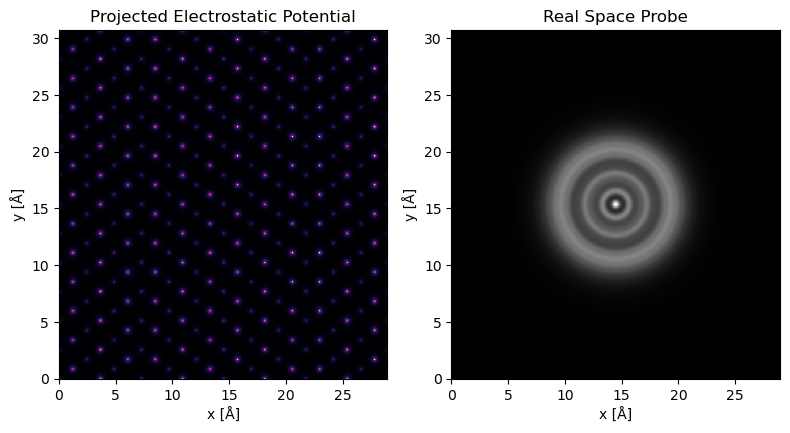

In [37]:
atoms_final = abtem.structures.orthogonalize_cell(afm_twin)*(1,6,8)
atoms_final.numbers[atoms_final.numbers==27]=28

electrostatic_potential = abtem.Potential(
    atoms_final,
    sampling=0.05,
    device='gpu',
    projection='infinite',
    parametrization='kirkland'
).build()

probe = abtem.Probe(
    defocus=300,
    semiangle_cutoff=25,
    energy=200e3,
    device='gpu'
)

probe.match_grid(electrostatic_potential)
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,6))
electrostatic_potential.project().show(cmap='magma',figsize=(4,4),title='Projected Electrostatic Potential',ax=ax1)
probe.show(figsize=(4,4),title='Real Space Probe',ax=ax2)
fig.tight_layout()

In [38]:
from cupyx.scipy.ndimage import zoom
import cupy as cp

vector_potential_z_resized = vector_potential_z_tiled.copy().transpose(1, 0, 2)
zoom_factor = np.array(electrostatic_potential.array.shape)/np.array(vector_potential_z_resized.shape)

vector_potential_z_resized = zoom(cp.asarray(vector_potential_z_resized),zoom_factor)
max_magnetic = cp.sum(vector_potential_z_resized,axis=0).max()
vector_potential_z_resized *= 2e-4*(atoms_final.cell.lengths()[2])/abtem.utils.energy2sigma(probe.energy)/max_magnetic

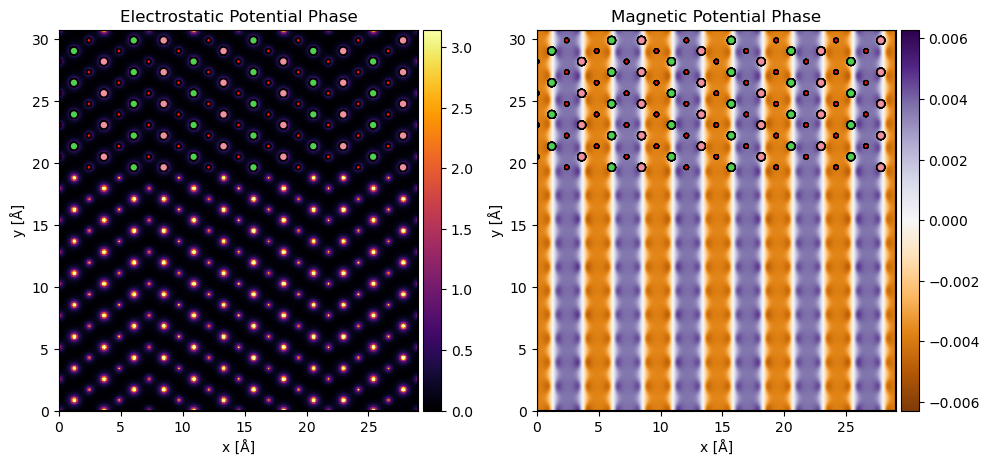

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

NiO_111_top_left = abtem.structures.orthogonalize_cell(afm_twin)*(1,6,16)
del NiO_111_top_left[np.where((NiO_111_top_left.positions[:,1]<19))[0]]

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6))

_,im1 = (electrostatic_potential.project()*abtem.utils.energy2sigma(probe.energy)).show(
    cmap='inferno',ax=ax1,vmax=np.pi)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax, orientation='vertical')

abtem.show_atoms(NiO_111_top_left, ax = ax1,scale_atoms=0.25)
ax1.set_xlim(extent_xy[0],extent_xy[1])
ax1.set_ylim(extent_xy[2],extent_xy[3])


ax1.set_title("Electrostatic Potential Phase")

im2=ax2.imshow(
    np.sum(vector_potential_z_resized.get()*abtem.utils.energy2sigma(probe.energy),axis=0).T,
    cmap='PuOr',
    vmin=-np.pi*2e-3,
    vmax=np.pi*2e-3,
    origin='lower',
    extent=extent_xy
)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

abtem.show_atoms(NiO_111_top_left, ax = ax2,scale_atoms=0.25)
ax2.set_xlim(extent_xy[0],extent_xy[1])
ax2.set_ylim(extent_xy[2],extent_xy[3])
ax2.set_title("Magnetic Potential Phase");

fig.tight_layout();

In [40]:
ground_truth_electrostatic = (electrostatic_potential.project()*abtem.utils.energy2sigma(probe.energy)).array
ground_truth_magnetic = np.sum(vector_potential_z_resized.get()*abtem.utils.energy2sigma(probe.energy),axis=0)

In [ ]:
# np.save("NiO-twin_ground-truth_electrostatic.npy",ground_truth_electrostatic)
# np.save("NiO-twin_ground-truth_magnetic.npy",ground_truth_magnetic)

In [41]:
from abtem import PixelatedDetector, GridScan

resample = probe.angular_sampling[0]
pixelated_detector = PixelatedDetector(max_angle=70,resample=(resample,)*2)
gridscan = abtem.GridScan(
    (0, 0), electrostatic_potential.extent, sampling=2,
    endpoint=True
)

modified_potential_forward = electrostatic_potential.copy()
modified_potential_forward._array += vector_potential_z_resized

measurement_forward = probe.scan(
    potential=modified_potential_forward,
    scan=gridscan,
    detectors=pixelated_detector, 
)

modified_potential_reverse = electrostatic_potential.copy()
modified_potential_reverse._array -= vector_potential_z_resized

measurement_reverse = probe.scan(
    potential=modified_potential_reverse,
    scan=gridscan,
    detectors=pixelated_detector, 
)

Scan:   0%|          | 0/256 [00:00<?, ?it/s]

Scan:   0%|          | 0/256 [00:00<?, ?it/s]

In [42]:
from abtem.noise import poisson_noise
measurement_forward_noisy = poisson_noise(measurement_forward,dose=1e6)
measurement_reverse_noisy = poisson_noise(measurement_reverse,dose=1e6)

In [43]:
from py4DSTEM import DataCube

datacube_forward = DataCube(measurement_forward_noisy.copy().array)
calibration_forward = datacube_forward.calibration
calibration_forward.set_R_pixel_size(measurement_forward_noisy.calibrations[0].sampling)
calibration_forward.set_R_pixel_units('A')
calibration_forward.set_Q_pixel_size(measurement_forward_noisy.calibrations[-1].sampling)
calibration_forward.set_Q_pixel_units('mrad')

datacube_reverse = DataCube(measurement_reverse_noisy.copy().array)
calibration_reverse = datacube_reverse.calibration
calibration_reverse.set_R_pixel_size(measurement_reverse_noisy.calibrations[0].sampling)
calibration_reverse.set_R_pixel_units('A')
calibration_reverse.set_Q_pixel_size(measurement_reverse_noisy.calibrations[-1].sampling)
calibration_reverse.set_Q_pixel_units('mrad')

datacube_reverse.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.8646916077252439
             R_pixel_size:    1.9335865064119269
             Q_pixel_units:   mrad
             R_pixel_units:   A
)

In [ ]:
# py4DSTEM.save("NiO-twin_forward_1e6.h5",datacube_forward)
# py4DSTEM.save("NiO-twin_reverse_1e6.h5",datacube_reverse)

#### Mixed Twin

In [44]:
primitive_cell_volume = np.fromfile('NiO-afm-mixed-twin-totalE.n_diff').reshape((336,36,60))
uvw_init = standardized_cell_mix_twin.cell.array
uvw_init

array([[29.0037976 ,  0.        ,  0.        ],
       [ 0.        ,  2.9601877 ,  0.        ],
       [ 0.        ,  0.        ,  5.12719549]])

In [45]:
symm_dataset = spglib.get_symmetry_dataset(mix_twin)
np.round(symm_dataset['transformation_matrix'].T,decimals=4)

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [46]:
u0 = np.array([1,0,0])
v0 = np.array([0,0,1])
w0 = np.array([0,1,0])

V0 = np.abs(np.cross(uvw_init[0,:],uvw_init[1,:]) @ uvw_init[2,:])

u = uvw_init.T @ u0
v = uvw_init.T @ v0
w = uvw_init.T @ w0

V = np.abs(np.cross(u,v) @ w)

print('volume change = ' + str(V / V0))
uvw = np.vstack((u,v,w))

print(np.round(uvw,decimals=8))

cell_dim = np.sqrt(np.sum(uvw**2,axis=1))
n = uvw / cell_dim[:,None]
uvw_proj = uvw_init @ np.linalg.inv(n)

print(np.round(uvw_proj,decimals=3))

volume change = 1.0000000000000002
[[29.0037976   0.          0.        ]
 [ 0.          0.          5.12719549]
 [ 0.          2.9601877   0.        ]]
[[29.004  0.     0.   ]
 [ 0.     0.     2.96 ]
 [ 0.     5.127  0.   ]]


In [47]:
# sampling of input
voxel_input = np.sqrt(np.sum(uvw_init**2,axis=1)) / primitive_cell_volume.shape

# sampling of output
voxel_output = np.min(voxel_input)
size_output = np.round(cell_dim / voxel_output).astype('int')
voxel_output = cell_dim / size_output

# Generate output volume
vol_output = np.zeros(size_output)
vol_count = np.zeros(size_output)

for a0 in range(1):
    # Projected coordinate system
    x0 = np.linspace(0,1,primitive_cell_volume.shape[0],endpoint=False) 
    y0 = np.linspace(0,1,primitive_cell_volume.shape[1],endpoint=False) + a0
    z0 = np.linspace(0,1,primitive_cell_volume.shape[2],endpoint=False)
    [xa,ya,za] = np.meshgrid(x0,y0,z0,indexing='ij')
    p0 = np.vstack((xa.ravel(),ya.ravel(),za.ravel()))
    p = uvw_proj.T @ p0
    p_inds = p / voxel_output[:,None]
    
    # trilinear sampling
    x = p_inds[0,:]
    y = p_inds[1,:]
    z = p_inds[2,:]
    xF = np.floor(x).astype('int')
    yF = np.floor(y).astype('int')
    zF = np.floor(z).astype('int')
    dx = x - xF
    dy = y - yF
    dz = z - zF
    
    # resample output
    inds_1D = np.ravel_multi_index(
        np.hstack([
            [xF  ,yF  ,zF  ], 
            [xF+1,yF  ,zF  ], 
            [xF  ,yF+1,zF  ], 
            [xF+1,yF+1,zF  ], 
            [xF  ,yF  ,zF+1], 
            [xF+1,yF  ,zF+1], 
            [xF  ,yF+1,zF+1], 
            [xF+1,yF+1,zF+1], 
        ]),
        size_output, 
        mode=['wrap','wrap','wrap'])
    weights = np.hstack((
            (1-dx)*(1-dy)*(1-dz),
            (  dx)*(1-dy)*(1-dz),
            (1-dx)*(  dy)*(1-dz),
            (  dx)*(  dy)*(1-dz),
            (1-dx)*(1-dy)*(  dz),
            (  dx)*(1-dy)*(  dz),
            (1-dx)*(  dy)*(  dz),
            (  dx)*(  dy)*(  dz),
    ))
    vol_count += np.reshape(np.bincount(
        inds_1D,
        weights=weights,
        minlength=vol_count.size),size_output)
    vol_output += np.reshape(np.bincount(
        inds_1D,
        weights=weights * np.tile(primitive_cell_volume.ravel(),8),
        minlength=vol_count.size),size_output)

# kernel density estimate
sigma = 0.25
vol_count = gaussian_filter(vol_count, sigma, mode ='wrap')
vol_count[vol_count==0.0] = np.inf
vol_output = gaussian_filter(vol_output, sigma, mode ='wrap')
vol_output /= vol_count

from scipy.ndimage import shift

vol_output = shift(vol_output,np.array([0,13.5,0]),order=0,mode='wrap')

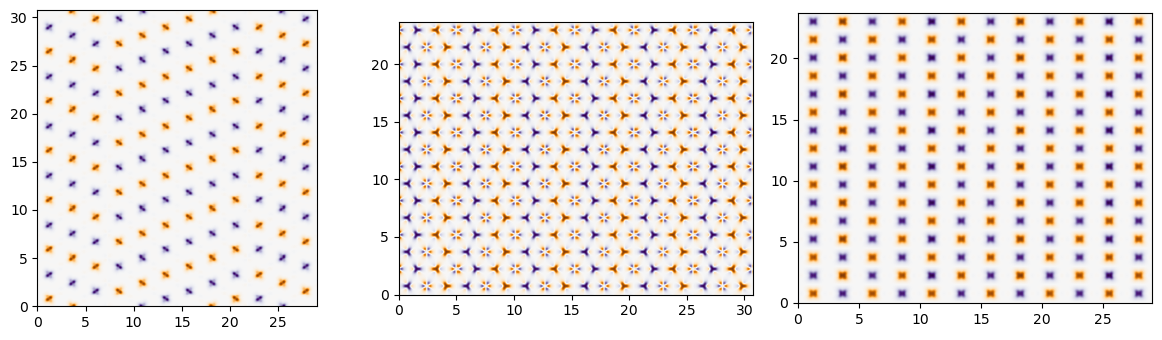

In [48]:
# plot magnetization

cmap = 'PuOr'
tile = (1,6,8)

tiled_output = np.tile(vol_output,tile)

extent = voxel_output*vol_output.shape*tile

extent_xy = [
    0,extent[0],
    0,extent[1]
    ]

extent_yz = [
    0,extent[1],
    0,extent[2]
    ]

extent_xz = [
    0,extent[0],
    0,extent[2]
    ]

fig,ax = plt.subplots(1,3,figsize=(12,3.5))
ax[0].imshow(
    np.sum(tiled_output,axis=2).T,
    cmap=cmap,
    origin='lower',
    extent=extent_xy
)
ax[1].imshow(
    np.sum(tiled_output,axis=0).T ,
    cmap=cmap,
    origin='lower',
    extent=extent_yz
)
ax[2].imshow(
    np.sum(tiled_output,axis=1).T,
    cmap=cmap,
    origin='lower',
    extent=extent_xz
);

fig.tight_layout()

In [49]:
from scipy.signal import fftconvolve, oaconvolve

tiled_output = np.tile(vol_output,(2,2,2))

xx,yy,zz = tuple(np.linspace(-(shape-1)/2,(shape-1)/2,shape)*sx for shape,sx in zip(vol_output.shape,voxel_output))
xx,yy,zz = np.meshgrid(xx,yy,zz,indexing='ij')

rvec = np.stack((xx, yy, zz), axis=0)
r = np.sqrt(xx**2 + yy**2 + zz**2)
r3 = r**3
r3[r3==0]=np.inf

rvec_over_rcubed = rvec/r3[None]

mu = np.array([1,0,0])
mu_cross_r = np.cross(mu, rvec_over_rcubed, axis=0) 

vector_potential_x =fftconvolve(mu_cross_r[0],tiled_output,mode='same')
vector_potential_y =fftconvolve(mu_cross_r[1],tiled_output,mode='same')
vector_potential_z =fftconvolve(mu_cross_r[2],tiled_output,mode='same')

vector_potential_x_tiled = np.tile(vector_potential_x,tile)
vector_potential_y_tiled = np.tile(vector_potential_y,tile)
vector_potential_z_tiled = np.tile(vector_potential_z,tile)

In [ ]:
# from ase.io import write
# write("NiO-mix-twin_atoms.xyz",abtem.structures.orthogonalize_cell(mix_twin))

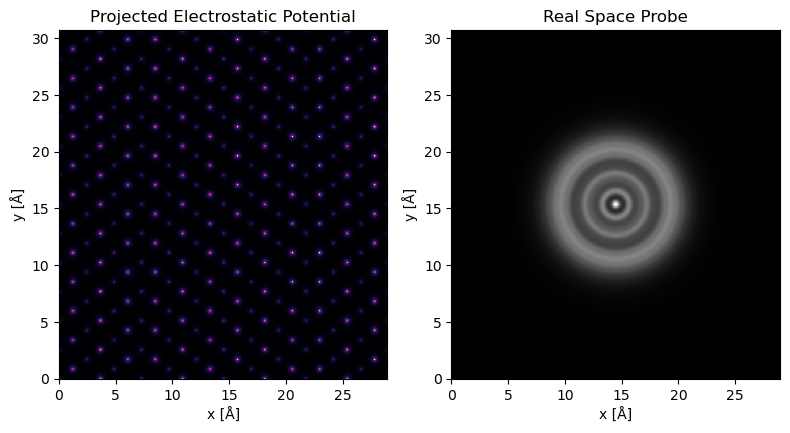

In [50]:
atoms_final = abtem.structures.orthogonalize_cell(mix_twin)*(1,6,8)
atoms_final.numbers[atoms_final.numbers==27]=28

electrostatic_potential = abtem.Potential(
    atoms_final,
    sampling=0.05,
    device='gpu',
    projection='infinite',
    parametrization='kirkland'
).build()

probe = abtem.Probe(
    defocus=300,
    semiangle_cutoff=25,
    energy=200e3,
    device='gpu'
)

probe.match_grid(electrostatic_potential)
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,6))
electrostatic_potential.project().show(cmap='magma',figsize=(4,4),title='Projected Electrostatic Potential',ax=ax1)
probe.show(figsize=(4,4),title='Real Space Probe',ax=ax2)
fig.tight_layout()

In [51]:
from cupyx.scipy.ndimage import zoom
import cupy as cp

vector_potential_z_resized = (vector_potential_z_tiled.copy().transpose(2, 0, 1))[:,::-1]
zoom_factor = np.array(electrostatic_potential.array.shape)/np.array(vector_potential_z_resized.shape)

vector_potential_z_resized = zoom(cp.asarray(vector_potential_z_resized),zoom_factor)
max_magnetic = cp.sum(vector_potential_z_resized,axis=0).max()
vector_potential_z_resized *= 2e-4*(atoms_final.cell.lengths()[2])/abtem.utils.energy2sigma(probe.energy)/max_magnetic

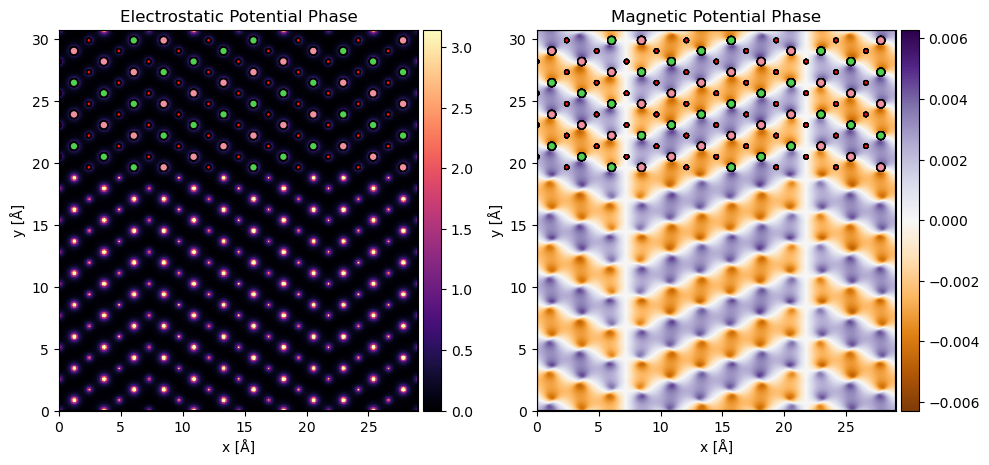

In [52]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

NiO_111_top_left = abtem.structures.orthogonalize_cell(mix_twin)*(1,6,16)
del NiO_111_top_left[np.where((NiO_111_top_left.positions[:,1]<19))[0]]

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6))

_,im1 = (electrostatic_potential.project()*abtem.utils.energy2sigma(probe.energy)).show(cmap='magma',ax=ax1,vmax=np.pi)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax, orientation='vertical')

abtem.show_atoms(NiO_111_top_left, ax = ax1,scale_atoms=0.25)
ax1.set_xlim(extent_xy[0],extent_xy[1])
ax1.set_ylim(extent_xy[2],extent_xy[3])


ax1.set_title("Electrostatic Potential Phase")

im2=ax2.imshow(
    np.sum(vector_potential_z_resized.get()*abtem.utils.energy2sigma(probe.energy),axis=0).T,
    cmap='PuOr',
    vmin=-np.pi*2e-3,
    vmax=np.pi*2e-3,
    origin='lower',
    extent=extent_xy
)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

abtem.show_atoms(NiO_111_top_left, ax = ax2,scale_atoms=0.25)
ax2.set_xlim(extent_xy[0],extent_xy[1])
ax2.set_ylim(extent_xy[2],extent_xy[3])
ax2.set_title("Magnetic Potential Phase");

fig.tight_layout();

In [53]:
ground_truth_electrostatic = (electrostatic_potential.project()*abtem.utils.energy2sigma(probe.energy)).array
ground_truth_magnetic = np.sum(vector_potential_z_resized.get()*abtem.utils.energy2sigma(probe.energy),axis=0)

In [ ]:
# np.save("NiO-mix-twin_ground-truth_electrostatic.npy",ground_truth_electrostatic)
# np.save("NiO-mix-twin_ground-truth_magnetic.npy",ground_truth_magnetic)

In [54]:
from abtem import PixelatedDetector, GridScan

resample = probe.angular_sampling[0]
pixelated_detector = PixelatedDetector(max_angle=70,resample=(resample,)*2)
gridscan = abtem.GridScan(
    (0, 0), electrostatic_potential.extent, sampling=2,
    endpoint=True
)

modified_potential_forward = electrostatic_potential.copy()
modified_potential_forward._array += vector_potential_z_resized

measurement_forward = probe.scan(
    potential=modified_potential_forward,
    scan=gridscan,
    detectors=pixelated_detector, 
)

modified_potential_reverse = electrostatic_potential.copy()
modified_potential_reverse._array -= vector_potential_z_resized

measurement_reverse = probe.scan(
    potential=modified_potential_reverse,
    scan=gridscan,
    detectors=pixelated_detector, 
)

Scan:   0%|          | 0/256 [00:00<?, ?it/s]

Scan:   0%|          | 0/256 [00:00<?, ?it/s]

In [55]:
from abtem.noise import poisson_noise
measurement_forward_noisy = poisson_noise(measurement_forward,dose=1e6)
measurement_reverse_noisy = poisson_noise(measurement_reverse,dose=1e6)

In [56]:
from py4DSTEM import DataCube

datacube_forward = DataCube(measurement_forward_noisy.copy().array)
calibration_forward = datacube_forward.calibration
calibration_forward.set_R_pixel_size(measurement_forward_noisy.calibrations[0].sampling)
calibration_forward.set_R_pixel_units('A')
calibration_forward.set_Q_pixel_size(measurement_forward_noisy.calibrations[-1].sampling)
calibration_forward.set_Q_pixel_units('mrad')

datacube_reverse = DataCube(measurement_reverse_noisy.copy().array)
calibration_reverse = datacube_reverse.calibration
calibration_reverse.set_R_pixel_size(measurement_reverse_noisy.calibrations[0].sampling)
calibration_reverse.set_R_pixel_units('A')
calibration_reverse.set_Q_pixel_size(measurement_reverse_noisy.calibrations[-1].sampling)
calibration_reverse.set_Q_pixel_units('mrad')

datacube_reverse.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.8646916077252439
             R_pixel_size:    1.9335865064119269
             Q_pixel_units:   mrad
             R_pixel_units:   A
)

In [ ]:
# py4DSTEM.save("NiO-mix-twin_forward_1e6.h5",datacube_forward)
# py4DSTEM.save("NiO-mix-twin_reverse_1e6.h5",datacube_reverse)